# Toy example for Data Assimilation

The aim of data assimilation is to reduce the uncertainties in models with the help of observations.
In this notebook the Kalman Filter and the 4D-Var methods are compared. First with a linear model and then with the classical [Lorenz 1969 model](https://doi.org/10.1175/1520-0469%281963%29020%3C0130:DNF%3E2.0.CO;2).

In [1]:
using DataAssim
using LinearAlgebra
using Plots
using Random
using Test

# State vector

$\newcommand{\e}[1]{{\bf \color{red}{#1}}}$
$\newcommand{\tindex}{k}$
$\renewcommand{\vec}[1] {{\mathbf #1}}$
$\renewcommand{\mat}[1] {{\mathbf #1}}$

The state vector $\vec x_\tindex$ containing all _prognostic_ variables at time $t_\tindex$ (time of the $\tindex$-th time step).

# Model
A model `ℳ` need to define the following operations:

* a foreward step: `ℳ(t,x,η)`
* tangent linear model: `tgl(ℳ,t,x,dx)`
* adjoint model: `adj(ℳ,t,x,dx2)`

η is random noise for a stochastic model or zero for a detministic model.

In [2]:
function check(ℳ::AbstractModel,n,t = 0,ϵ = 1e-4)
    dx = randn(n)
    x = randn(n)
    dx2 = randn(n)
    @test (ℳ(t,x + ϵ.*dx) - ℳ(t,x - ϵ.*dx)) / (2*ϵ)  ≈ tgl(ℳ,t,x,dx) atol=10*ϵ^2
    @test dx2 ⋅ tgl(ℳ,t,x,dx) ≈ adj(ℳ,t,x,dx2) ⋅ dx   atol=1e-7

    dX = randn(n,3)
    MdX = tgl(ℳ,t,x,dX)
    @test tgl(ℳ,t,x,dX[:,1]) ≈ MdX[:,1]
end

check (generic function with 3 methods)

Simple model can be defined using matrix `ModelMatrix(M)`

$$
\vec x_{\tindex+1} = \mat M \; \vec x_\tindex 
$$

In [3]:
ℳ = ModelMatrix(2*I)

x = randn(90)
@test ℳ(0,x) ≈ 2*x
@test tgl(ℳ,0,0,x) ≈ 2*x
@test adj(ℳ,0,0,x) ≈ 2*x
check(ℳ,4)

Test Passed

Or using a operator $\cal M$, potentially non-linear:


$$
\vec x_{\tindex+1} = \cal M(t_\tindex, \vec x_\tindex)
$$

In this case, the tagent linear and adjoint model have to be provided too (or derived from automatic differential tools)

In [4]:
ℳ = ModelFun((t,x,η) -> 2*x,(t,x,dx) -> 2*dx,(t,x,dx) -> 2*dx)

x = randn(10)
@test ℳ(0,x) ≈ 2*x
@test tgl(ℳ,0,0,x) ≈ 2*x
@test adj(ℳ,0,0,x) ≈ 2*x
check(ℳ,10)

Test Passed

# Shallow water 1D model

In [5]:
dt = 0.5 
g = 9.81
h = 100.0
L = 10000.0
n = 1000

ℳ = LinShallowWater1DModel(dt, g, h, L, n)
check(ℳ,2*n-1)

Test Passed

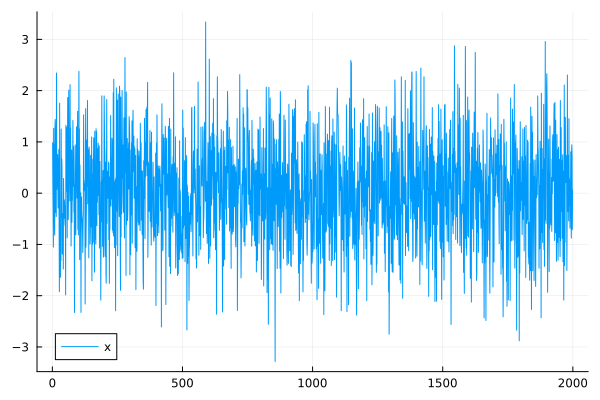

In [6]:
ζ0 = randn(n - 1)
u0 = randn(n)
x = pack(ℳ, ζ0, u0)
p = Plots.plot(x, label="x")
Plots.display(p)

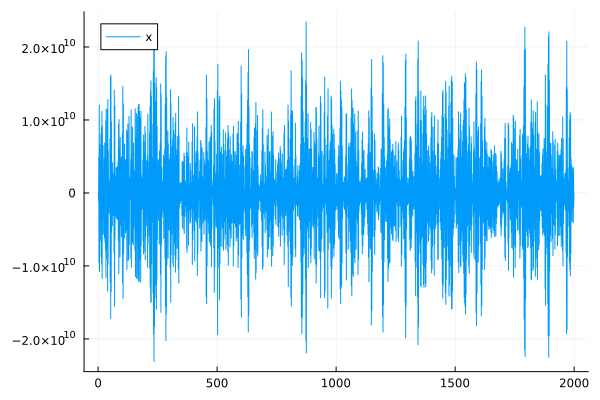

In [7]:
nt = 20  
x = pack(ℳ, ζ0, u0)
for n in 1:nt
    x = ℳ(n, x)  
end

p = Plots.plot(x, label="x")
Plots.display(p)

1999×1999 Matrix{Float64}:
 10.0   0.0   0.0   0.0   0.0   0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0  10.0   0.0   0.0   0.0   0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0   0.0  10.0   0.0   0.0   0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0   0.0   0.0  10.0   0.0   0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0   0.0   0.0   0.0  10.0   0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0   0.0   0.0   0.0   0.0  10.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0   0.0   0.0   0.0   0.0   0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0   0.0   0.0   0.0   0.0   0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0   0.0   0.0   0.0   0.0   0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0   0.0   0.0   0.0   0.0   0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  ⋮                             ⋮    ⋱                 ⋮              
  0.0   0.0   0.0   0.0   0.0   0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0   0.0   0.0   0.0   0.0   0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0   0.0   

1999-element Vector{Float64}:
   1.9999999999999967
   1.9999999999999967
   1.9999999999999976
   1.9999999999999976
   1.9999999999999976
   1.9999999999999976
   1.999999999999998
   1.999999999999998
   1.9999999999999984
   1.9999999999999984
   ⋮
  73.37165319237938
 147.7797330647485
 243.36656064364175
 352.38825963536914
 466.0125403646303
 575.0342393563578
 670.6210669352514
 745.0291468076209
 792.2303788640968

false


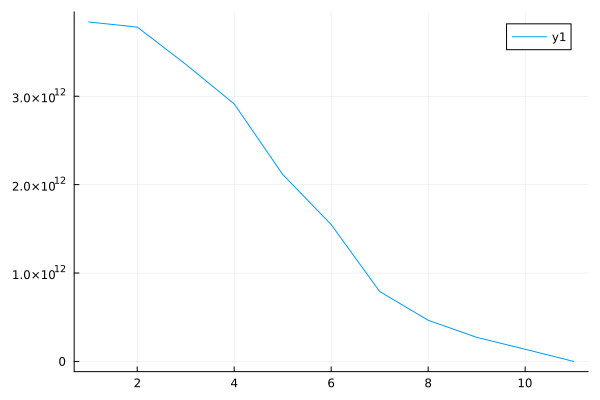

In [8]:
#dt = 1.0
#g = 9.81
#h = 100
#n = 101
#L = 10000.0
m = 10

#ℳ = LinShallowWater1DModel(dt, g, h, L, n)

nmax = 8;
no = 1:2:nmax;
ζ0 = randn(n - 1)
u0 = randn(n)
xit = pack(ℳ, ζ0, u0);
H = Matrix(I, m, 2*n-1);
𝓗 = ModelMatrix(H)
Pi = Matrix(0.5*I,2*n-1,2*n-1)
Q = zeros(2*n-1,2*n-1)

R = [Matrix(0.5*I, m, m) for n in no]
xt, xfree, xa, yt, yo, diag_ , Aerrors = TwinExperiment(ℳ, xit, Pi, Q, R, 𝓗, nmax, no, "4DVar")
Plots.plot(Aerrors)

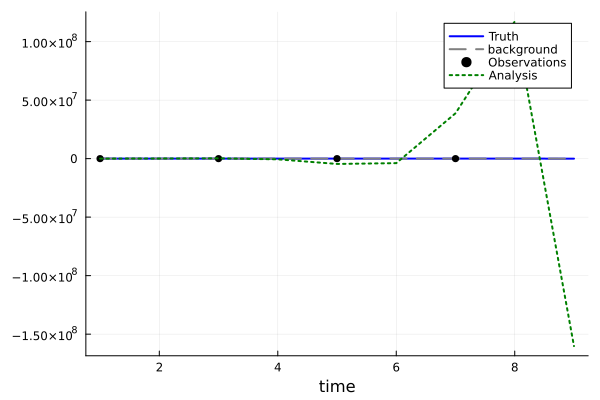

In [9]:
time = 1:nmax+1

p = Plots.plot(
    time, xt[2, :],
    label = "Truth", lw = 2, color = :blue,
    xlabel = "time",
    legend = :topright,
    grid = :on,
)

Plots.plot!(
    p, time, xfree[2, :],
    label = "background", lw = 2, linestyle = :dash, color = :gray
)

Plots.plot!(
    p, time[no], getindex.(yo, 2),
    label = "Observations", seriestype = :scatter, marker = :circle, color = :black
)

Plots.plot!(
    p, time, xa[2, :],
    label = "Analysis", lw = 2, linestyle = :dot, color = :green
)

Plots.display(p)
